# Сервис по продаже автомобилей с пробегом «Не бит, не крашен» 

## Задание

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Описание данных 

- **DateCrawled** — дата скачивания анкеты из базы
- **VehicleType** — тип автомобильного кузова
- **RegistrationYear** — год регистрации автомобиля
- **Gearbox** — тип коробки передач
- **Power** — мощность (л. с.)
- **Model** — модель автомобиля
- **Kilometer** — пробег (км)
- **RegistrationMonth** — месяц регистрации автомобиля
- **FuelType** — тип топлива
- **Brand** — марка автомобиля
- **NotRepaired** — была машина в ремонте или нет
- **DateCreated** — дата создания анкеты
- **NumberOfPictures** — количество фотографий автомобиля
- **PostalCode** — почтовый индекс владельца анкеты (пользователя)
- **LastSeen** — дата последней активности пользователя


Целевой признак


- **Price** — цена (евро)

## Подключение библиотек 

In [1]:
import pandas as pd

!pip install seaborn -U
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score

/bin/bash: pip: команда не найдена


## Подготовка данных

### Загрузка данных

In [2]:
data = pd.read_csv('/datasets/autos.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


In [4]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


#### Вывод

Пропуски содержаться в следующих полях:
- VehicleType
- Gearbox
- Model
- FuelType
- NotRepaired

Неправильный тип данных у следующих полей:

- DateCrawled - **date**
- NotRepaired - **bool**
- DateCreated - **date**
- LastSeen    - **date**

### Обработка пропусков 

#### Поля VehicleType, Gearbox, Model, FuelType 

Ясно, что эти поля влияют друг на друга, заполним их методом случайного леса.

##### Подготовка данных 

In [5]:
data4fill = data.dropna()[['VehicleType','Gearbox','Model','FuelType','Brand']]

In [6]:
data4fill.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 245814 entries, 3 to 354367
Data columns (total 5 columns):
VehicleType    245814 non-null object
Gearbox        245814 non-null object
Model          245814 non-null object
FuelType       245814 non-null object
Brand          245814 non-null object
dtypes: object(5)
memory usage: 11.3+ MB


In [7]:
data4fill.head()

,VehicleType,Gearbox,Model,FuelType,Brand
3,small,manual,golf,petrol,volkswagen
4,small,manual,fabia,gasoline,skoda
5,sedan,manual,3er,petrol,bmw
6,convertible,manual,2_reihe,petrol,peugeot
7,sedan,manual,other,petrol,volkswagen


In [8]:
def present(count__x_percent, count_100_percent = len(data)):
    return 100/ (count_100_percent / count__x_percent)

In [9]:
def split_x_y(data, column):
    x = data.drop(column, axis=1)
    y = data[column]
    return x, y

In [10]:
class DataFiller:
    model = 0
    col_target = 0
    cols_train = 0
    data = 0
    lbEncoder = 0
    
    df_train_x = 0
    df_train_y = 0
    
    def __init__(self, data, col_target):
        self.data = data
        self.col_target = col_target
   
    
    def my_train_test_split(self):
        df_train, df_test = train_test_split(self.data, test_size=0.25, random_state=12345)
    
        df_train_x, df_train_y = split_x_y(df_train, self.col_target)
        df_test_x, df_test_y = split_x_y(df_test, self.col_target)
    
        return df_train_x, df_train_y, df_test_x, df_test_y
    
    def labels_encoder(self):
        self.lbEncoder = LabelEncoder()
        self.lbEncoder.fit(self.data[self.col_target])
        self.df_train_y = self.lbEncoder.transform(self.df_train_y)
        

    def train(self, max_depth):
        
        self.df_train_x, self.df_train_y, df_test_x, df_test_y =     self.my_train_test_split()
        self.cols_train = self.df_train_x.columns
        
        self.labels_encoder()    
     
        self.df_train_x = pd.get_dummies(self.df_train_x, drop_first=True)
        
        self.model = RandomForestClassifier(max_depth=max_depth, random_state=0)
        self.model.fit(self.df_train_x, self.df_train_y)
        
        predicts = self.predict(df_test_x)
        predicts = self.lbEncoder.transform(predicts)
        
        df_test_y = self.lbEncoder.transform(df_test_y)
        
        return accuracy_score(predicts, df_test_y)
    
    def do_same_columns(self, train, test ):
        missing_cols = set( train.columns ) - set( test.columns )
        for c in missing_cols:
            test[c] = 0
        test = test[train.columns]
        return test
    
    def predict(self,df_test_x):
        df_test_x = pd.get_dummies(df_test_x, drop_first=True)
        df_test_x = self.do_same_columns(self.df_train_x, df_test_x)
        
        if len(df_test_x) == 0:
            return []
        
        
        predicts =  self.model.predict(df_test_x)
        return self.lbEncoder.inverse_transform(predicts)
    
    def prepare_for_filling(self, data):
        data_pred = data[data[self.col_target].isna()]
        data_pred = data_pred[self.cols_train]
        return data_pred.dropna()

In [11]:
def do_filling(dataFiller):
    data_pred = dataFiller.prepare_for_filling(data)
    predicts = dataFiller.predict(data_pred)
    data.loc[data_pred.index, dataFiller.col_target] = predicts
    
    print('Поле', dataFiller.col_target)
    print('Осталось пустых значений:', data[dataFiller.col_target].isna().sum())
    print('Осталось пустых значений в %:', present(data[dataFiller.col_target].isna().sum(), len(data)))

##### Поле VehicleType

In [12]:
dataFiller = DataFiller(data4fill, 'VehicleType' )

In [13]:
accuracy = dataFiller.train(30)

In [14]:
accuracy

0.6642692094900251

In [15]:
do_filling(dataFiller)

Поле VehicleType
Осталось пустых значений: 22388
Осталось пустых значений в %: 6.317708377425791


Попробуем понизить количество признаков используемых для предсказания 

In [16]:
dataFiller = DataFiller(data4fill[['Model','Brand','VehicleType']], 'VehicleType' )

In [17]:
accuracy = dataFiller.train(30)

In [18]:
accuracy

0.650714355452859

In [19]:
do_filling(dataFiller)

Поле VehicleType
Осталось пустых значений: 6828
Осталось пустых значений в %: 1.9268051099277872


удалим остаток

In [20]:
data = data.dropna(subset=['VehicleType'])

In [21]:
data['VehicleType'].isna().sum()

0

### Кодирование признаков 

### Поле Price

In [22]:
data['Price'].describe()

count    347541.000000
mean       4463.647975
std        4524.298684
min           0.000000
25%        1100.000000
50%        2799.000000
75%        6499.000000
max       20000.000000
Name: Price, dtype: float64

In [23]:
def visualize():
    fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(16, 10))    
    fig.suptitle('Распределения поля Price')
    
    ax = axes.flat
    
    axes[0].set_xlabel('Цена в евро')
    data.boxplot('Price',vert=False,  ax=ax[0])
    
    axes[1].set_ylabel('Относительная частота')
    axes[1].set_xlabel('Цена в евро')
    sns.histplot(data['Price'], kde=True, stat="probability", ax=ax[1])
    plt.show()

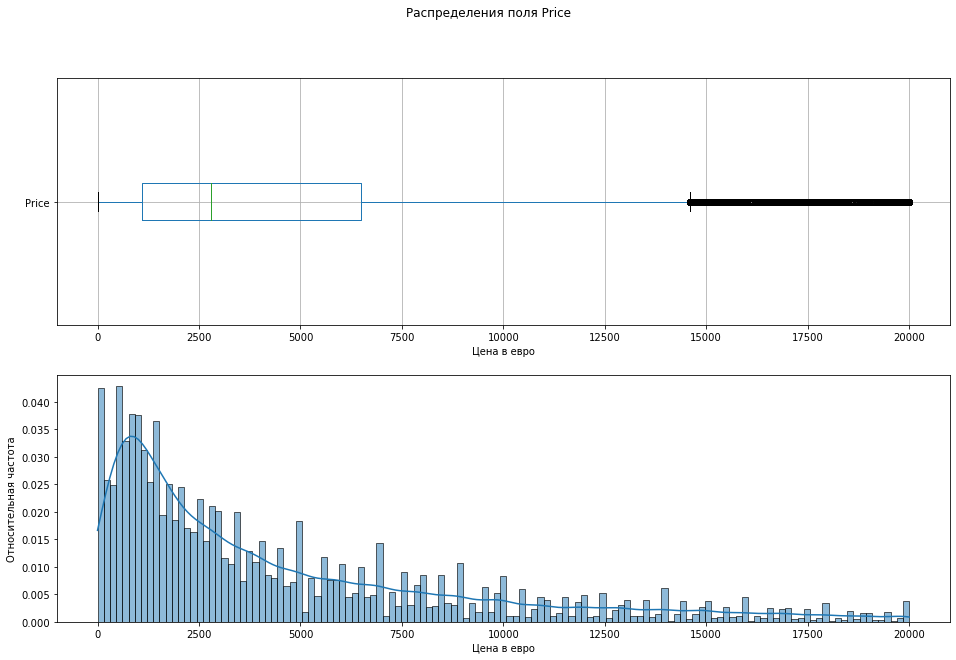

In [24]:
visualize()

#### Вывод

Поле имеет логнормальное распределение и не содержит выбросов. Однако машины с нулевой ценой вызывают подозрение, рассмотрим их отдельно.

### Деление выборки на features и target 

In [25]:
features, target  = split_x_y(data,'Price')

### Обработка полей не влияющих на цену 

Предположим, что на цену не влияют следующие поля:
    
- DateCrawled
- RegistrationMonth
- DateCreated
- NumberOfPictures
- PostalCode
- LastSeen

Проверим наши предположения 

# 2. Обучение моделей

# 3. Анализ моделей

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнена загрузка и подготовка данных
- [ ]  Выполнено обучение моделей
- [ ]  Есть анализ скорости работы и качества моделей